In [9]:
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.linalg import lstsq
from scipy.spatial import distance
import scipy 
import numpy as np
import random
import matplotlib


In [10]:
# loading images from mnist into datasets

X = loadmat("mnist.mat")
X_train = X['trainX'].reshape(60000,28,28)
Y_train = X['trainY'].reshape(60000,)
X_test  = X['testX'].reshape(10000,28,28)
Y_test  = X['testY'].reshape(10000,)

print('MNIST Dataset Shape:')
print('X_train: ' + str(X_train.shape))
print('Y_train: ' + str(Y_train.shape))
print('X_test:  '  + str(X_test.shape))
print('Y_test:  '  + str(Y_test.shape))

MNIST Dataset Shape:
X_train: (60000, 28, 28)
Y_train: (60000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)


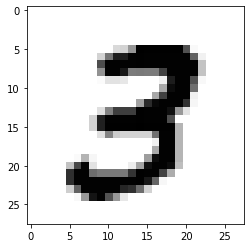

In [11]:
# displaying a sample from dataset
plt.figure()
plt.imshow(X_train[7].reshape(28,28), cmap='binary')
a = X_train.reshape(60000,784)

(60000, 493)

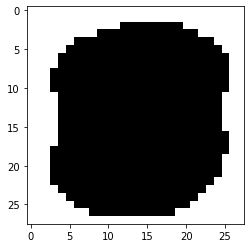

In [12]:
# Triming the images
mask= a.any(axis=0)
for col in range(a.shape[1]):

    non_zero_rows = np.count_nonzero(a[:,col])
    if (600 >=  non_zero_rows):
        mask[col]=False
    else:
        mask[col]=True
        

plt.imshow(mask.reshape(28,28), cmap='binary')
mask.shape

A = a[:,mask] 
A.shape        

In [13]:
#append a column of ones to the end of the array to consider alpha

A = np.append(A, np.ones((60000, 1), dtype=int), axis=1) 
A.shape

(60000, 494)

In [14]:
#cleaning the test data
test = X_test.reshape(10000,784)
test = test[:,mask]
#test.shape

In [15]:
#create training lables for one-vs-all

Y_train_stacked= np.empty((0,60000),dtype=int)
for num in range(10):
    Y_train_stacked = np.vstack((Y_train_stacked, np.where(Y_train == num, 1, -1)))  
print(Y_train_stacked.shape)


(10, 60000)


In [16]:
#solving for betas and alpha
beta_stacked= np.empty((0,494))
for num in range(10):
    beta, res, rnk, s = lstsq(A, Y_train_stacked[num])
    #beta = np.dot(np.linalg.pinv(np.dot(A.T, A)), np.dot(A.T, Y_train_stacked[num]))
    beta_stacked = np.vstack((beta_stacked, beta.T))
#print(beta_stacked.shape)
np.savetxt("beta_stacked.csv", beta_stacked, delimiter=",")

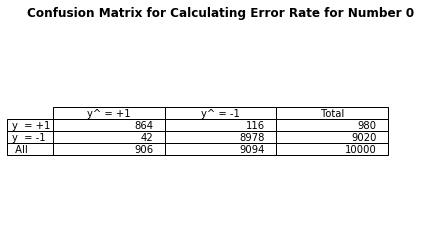

 Error Rate:  1.58 %
 Precision :  95.36423841059603 %
 True Positive Rate :  88.16326530612245 %
 False Positive Rate:  4.635761589403973 %


In [17]:
NUM_TO_CHECK_ERROR_RATE = 0 
confusion_matrix_num_0 =  np.zeros( (3, 3),dtype=int ) 

for n in range(10000):
    if(np.sign(test[n,:].T @ beta_stacked[NUM_TO_CHECK_ERROR_RATE,:-1] + beta_stacked[NUM_TO_CHECK_ERROR_RATE,-1]) > 0):
        if(Y_test[n]==NUM_TO_CHECK_ERROR_RATE):
            confusion_matrix_num_0[0 , 0 ] += 1
        else:
            confusion_matrix_num_0[1 , 0 ] += 1
            
    else:

        if(Y_test[n]==NUM_TO_CHECK_ERROR_RATE):
                
            confusion_matrix_num_0[0 , 1 ] += 1
        else:
            confusion_matrix_num_0[1 , 1 ] += 1


confusion_matrix_num_0[:,2]= confusion_matrix_num_0.sum(axis=1) 
confusion_matrix_num_0[2,:] = confusion_matrix_num_0.sum(axis=0)


   
N   = confusion_matrix_num_0[2,2]
Np  = confusion_matrix_num_0[0,2]
Nn  = confusion_matrix_num_0[2,0]
Nfp = confusion_matrix_num_0[1 , 0 ]
Nfn = confusion_matrix_num_0[0 , 1 ]
Ntp = confusion_matrix_num_0[0 , 0 ]
Ntn = confusion_matrix_num_0[1 , 1 ]


fig, ax = plt.subplots()
# hide axes
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')
collabel=("y^ = +1", "y^ = -1", " Total ")
rowlabel=("y  = +1", "y  = -1", " All ")
ax.table(cellText=confusion_matrix_num_0,rowLabels=rowlabel, colLabels=collabel, loc='center')
ax.set_title('Confusion Matrix for Calculating Error Rate for Number '+ str(NUM_TO_CHECK_ERROR_RATE), fontweight ="bold") 
#fig.tight_layout()
plt.show()


print(" Error Rate: ", ((Nfp + Nfn)/ N)*100, "%")
print(" Precision : ", (Ntp /(Ntp + Nfp))*100, "%")
print(" True Positive Rate : ", (Ntp/Np)*100, "%")
print(" False Positive Rate: ", (Nfp/Nn)*100, "%")

# one-vs-all 

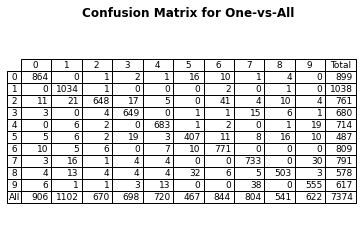

 Error Rate:  7.146731760238676 %


In [18]:
# testing and generating confusion matrix
confusion_matrix =  np.zeros( (11, 11),dtype=int ) 
for n in range(10000):
    for num in range(10):
        
        if(np.sign(test[n,:].T @ beta_stacked[num,:-1] + beta_stacked[num,-1]) > 0):

            if(Y_test[n]==num):
                confusion_matrix[num , num ] += 1
            else:
                confusion_matrix[Y_test[n], num ] += 1



            
confusion_matrix[:,10]= confusion_matrix.sum(axis=1) 
confusion_matrix[10,:] = confusion_matrix.sum(axis=0)

fig, ax = plt.subplots()
# hide axes
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')
collabel=(" 0 ", " 1 ", " 2 ", " 3 ", " 4 ", " 5 ", " 6 ", " 7 ", " 8 ", " 9 ", "Total")
rowlabel=(" 0 ", " 1 ", " 2 ", " 3 ", " 4 ", " 5 ", " 6 ", " 7 ", " 8 ", " 9 ", "All")
ax.table(cellText=confusion_matrix,rowLabels=rowlabel, colLabels=collabel, loc='center')
ax.set_title('Confusion Matrix for One-vs-All', fontweight ="bold") 
plt.show()



# calculating Error rate
err = 0
for i in range(10):
    err += confusion_matrix[i][-1] - confusion_matrix[i][i] 
print(" Error Rate: ", (err/ confusion_matrix[10,10])*100, "%")


# one-vs-one

In [19]:
import numpy as np
Nerr=0

one_vs_one_beta_stacked = np.empty((0, 494))

for i in range(0, 10):
    for j in range(i+1, 10): 
        #generate the traning data 
        arg1= np.where(Y_train == i)
        arg2= np.where(Y_train == j)
          
        
        X_train_one_vs_one_stacked = np.empty((0, 494))
        X_train_one_vs_one_stacked = np.vstack((X_train_one_vs_one_stacked, A[arg1])) 
        X_train_one_vs_one_stacked = np.vstack((X_train_one_vs_one_stacked, A[arg2]))
        
        
        #generate the labels 
        Y_train_one_vs_one_stacked = np.ones(((arg1[0].size + arg2[0].size), ), dtype=int)
        Y_train_one_vs_one_stacked[arg1[0].size:] =  -1 * Y_train_one_vs_one_stacked[arg1[0].size:]
        
        #generate the solution for betas and alpha and stack them on one array
        one_vs_one_beta, res, rnk, s = lstsq(X_train_one_vs_one_stacked, Y_train_one_vs_one_stacked) 
        one_vs_one_beta_stacked = np.vstack((one_vs_one_beta_stacked, one_vs_one_beta))
        print(".",end="")
        
        
print("Done!")
np.savetxt("one_vs_one/one_vs_one_beta_and_alpha.csv", one_vs_one_beta_stacked, delimiter=",")
        
#print(Y_train_one_vs_one_stacked.shape)
#print(one_vs_one_beta_stacked.shape)       
        


.............................................Done!


# <font color=blue>one-vs-one: testing and generating confusion matrix</font>

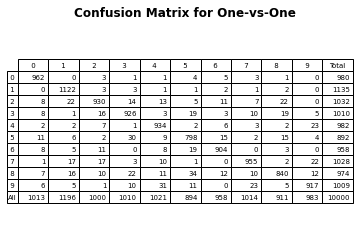

 Error Rate:  7.12 %


In [20]:
confusion_matrix_one_vs_one =  np.zeros( (11, 11),dtype=int )
for n in range(10000):
    
    num = 0
    vote = np.zeros((10,), dtype=int)
    
    for i in range(0, 10):
        for j in range(i+1, 10):

            if(np.sign(test[n,:].T @ one_vs_one_beta_stacked[num,:-1] + one_vs_one_beta_stacked[num,-1]) > 0):
                vote[i]+=1
                
            else:
                vote[j]+=1
             
            num += 1
             
    if(Y_test[n]==np.argmax(vote)):
        confusion_matrix_one_vs_one [Y_test[n] , Y_test[n]] += 1
    else:
        confusion_matrix_one_vs_one[Y_test[n], np.argmax(vote) ] +=  1
    #print(Y_test[n],": ", np.argmax(vote))       
    #print(np.sum(vote))
    
confusion_matrix_one_vs_one[:,10]= confusion_matrix_one_vs_one.sum(axis=1) 
confusion_matrix_one_vs_one[10,:] = confusion_matrix_one_vs_one.sum(axis=0)


fig, ax = plt.subplots()
# hide axes
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')
collabel=(" 0 ", " 1 ", " 2 ", " 3 ", " 4 ", " 5 ", " 6 ", " 7 ", " 8 ", " 9 ", "Total")
rowlabel=(" 0 ", " 1 ", " 2 ", " 3 ", " 4 ", " 5 ", " 6 ", " 7 ", " 8 ", " 9 ", "All")
ax.table(cellText=confusion_matrix_one_vs_one,rowLabels=rowlabel, colLabels=collabel, loc='center')
ax.set_title('Confusion Matrix for One-vs-One', fontweight ="bold") 
plt.show()

# calculating Error rate
err = 0
for i in range(10):
    err += confusion_matrix_one_vs_one[i][-1] - confusion_matrix_one_vs_one[i][i] 
    
print(" Error Rate: ", (err/ N)*100, "%")
               

# KMean





In [21]:
def k_mean(nrow, ncol):
    # iterate the operation for P times
    jclust = np.zeros((P,1))
    for ind in range(P):
        
        # regrouping
        G = [np.array(g) for g in [np.where(c==i) for i in range(K)]]
        
        #for i in range(K):
            #print(np.size(G[i][0]), end=" ")
        
        #regenerate group representatives Z1,..., Zk
        for i in range(K):
            for j in G[i][0]:
                Z[i] += a[j]
            Z[i] /= np.size(G[i][0])
            
            
        #creating Objective J^Clust
        J_clust=0
        for i in range(N):
            J_clust += distance.euclidean(a[i], Z[c[i]])
        J_clust /= N
        jclust[ind]= J_clust
        

        
        #minimize distances
        d= np.empty((N,K))
        for i in range(N):
            for j in range(K):
                #d[i][j] = distance.cdist(a[i].reshape(784,1), Z[j].reshape(784,1), 'euclidean')
                #d[i][j] = distance.euclidean(a[i], Z[j])
                d[i][j] = np.sqrt(np.sum((a[i] - Z[j]) ** 2, axis=0))
            c[i]= np.argmin(d[i]) 
            
        if ind==0 or ind==P-1 :
            fig, ax = plt.subplots(nrows=nrow, ncols=ncol)
            if nrow > 1:
                n = 0
                for index, row in enumerate(ax):
                    for col in row:
                        col.imshow(Z[n].reshape(28,28), cmap='binary')
                        n+=1
                ax[0][0].set_title('Group representatives found by the k-means, Iteration #'+ str(ind), fontweight ="bold")
            else:
                n = 0
                for row in ax:
                    row.imshow(Z[n].reshape(28,28), cmap='binary')
                    n+=1
                ax[0].set_title('Group representatives found by the k-means, Iteration #'+ str(ind), fontweight ="bold") 
            plt.show()
        print("." ,end="")   
            
    return(jclust, Z, c, d)
                   


## K = 20,  P = 30

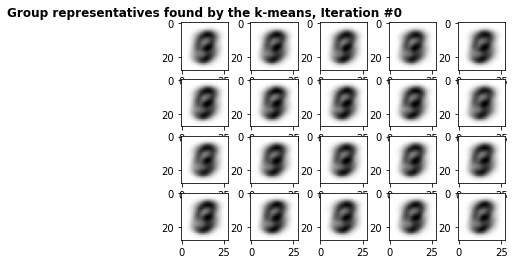

.............................

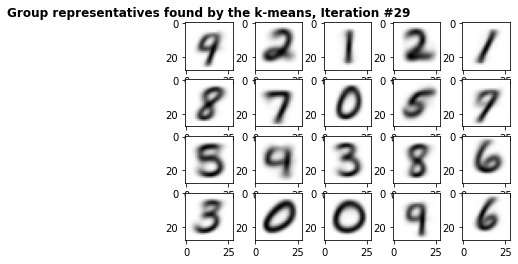

.

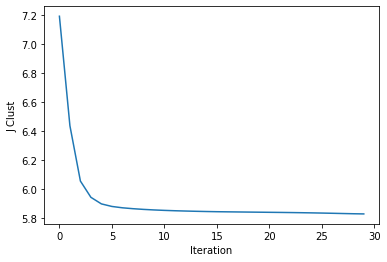

In [24]:
N = 60000                         # number of datapoints
K = 20                            # number of groups
P = 30                            # number of iterations
#reshape the training data
a = X_train.reshape(60000,784)
a = a.astype('float64')
a = a/255

c = np.zeros((N,), dtype=int)     #assigned groups c1,... ,cN
G = [[] for i in range(K)]        #Groups G1,... ,GK
Z = np.zeros((K, 784))            #reprezentatives Z1,..., Zk
Zk = np.zeros((K, 784))            
# random group assignment of images
for i in range(N):
    c[i]= random.randrange(K)
# creating groups
G = [np.array(g) for g in [np.where(c==i) for i in range(K)]]

#initializing the representatives Z1,..., Zk
Z = [a[np.where(c==i)[0][0]] for i in range(K)]

#execute the kmean
#it may take a long time to execute

J, Z, c, d = k_mean(4,5)

plt.plot(np.arange(0,P), J)
plt.ylabel('J Clust')
plt.xlabel('Iteration')
plt.show()


<font color=blue>Plot clearly shows exponential improvment in the values of objective vs iteration. </font>

<font color=blue> I can see that most of these representatives are easily recognizable. I can recognize 1, 2, 3 ,5 ,6 ...</font>




# K = 10,  P = 20




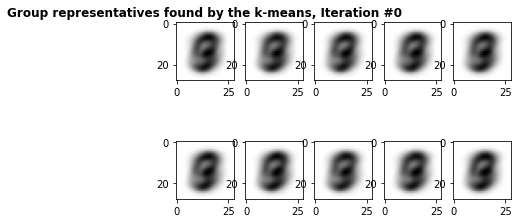

...................

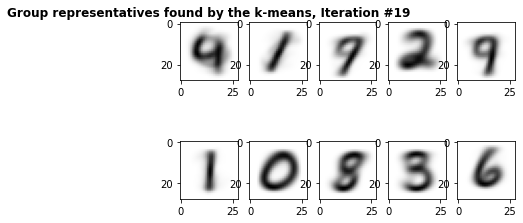

.

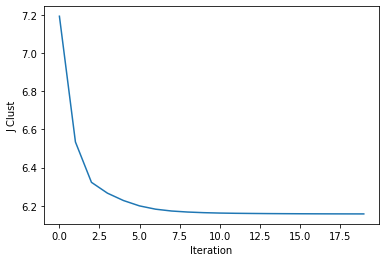

In [23]:
N = 60000                         # number of datapoints
K = 10                            # number of groups
P = 20                            # number of iterations
#reshape the training data
a = X_train.reshape(60000,784)
a = a.astype('float64')
a = a/255

c = np.zeros((N,), dtype=int)     #assigned groups c1,... ,cN
G = [[] for i in range(K)]        #Groups G1,... ,GK
Z = np.zeros((K, 784))            #reprezentatives Z1,..., Zk
# random group assignment of images
for i in range(N):
    c[i]= random.randrange(K)
# creating groups
G = [np.array(g) for g in [np.where(c==i) for i in range(K)]]

#initializing the representatives Z1,..., Zk
Z = [a[np.where(c==i)[0][0]] for i in range(K)]

#execute the kmean
#it may take a long time to execute
J, Z, c, d = k_mean(2,5)

plt.plot(np.arange(0,P), J)
plt.ylabel('J Clust')
plt.xlabel('Iteration')
plt.show()



# K = 5,  P = 10



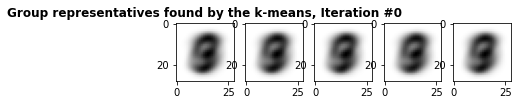

.........

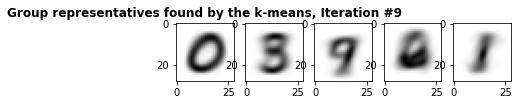

.

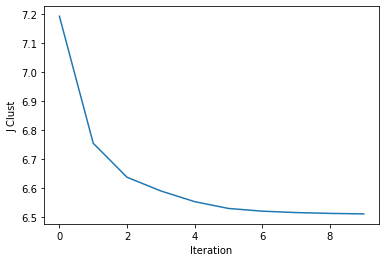

In [22]:
N = 60000                         # number of datapoints
K = 5                             # number of groups
P = 10                            # number of iterations
#reshape the training data
a = X_train.reshape(60000,784)
a = a.astype('float64')
a = a/255

c = np.zeros((N,), dtype=int)     #assigned groups c1,... ,cN
G = [[] for i in range(K)]        #Groups G1,... ,GK
Z = np.zeros((K, 784))            #reprezentatives Z1,..., Zk
# random group assignment of images
for i in range(N):
    c[i]= random.randrange(K)
# creating groups
G = [np.array(g) for g in [np.where(c==i) for i in range(K)]]

#initializing the representatives Z1,..., Zk
Z = [a[np.where(c==i)[0][0]] for i in range(K)]

#execute the kmean
#it may take a long time to execute
J, Z, c, d = k_mean(1,5)


plt.plot(np.arange(0,P), J)
plt.ylabel('J Clust')
plt.xlabel('Iteration')
plt.show()